In [2]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/projects/cft_vlm/finetune")

In [3]:
import matplotlib.pyplot as plt
import json
import re
from qwenvl.eval import comp_answer_basic, yes_no_filter, evaluate
import numpy as np


def draw_conf_mat(output_file):
  with open(output_file, "r") as f:
    items = [json.loads(line) for line in f]

  conf_mat = {
      "yes": {"yes": 0, "no": 0},
      "no": {"yes": 0, "no": 0}
  }
  answers = {
      "yes": {"yes": list(), "no": list()},
      "no": {"yes": list(), "no": list()}
  }
  invalid = {
    'yes': list(),
    'no': list()
  }
  for item in items:
    if item['answer'] not in ["yes", "no"]:
      continue
    model_answer = item.get('model_answer', '')
    model_answer = re.split(r'[^\w]+', model_answer.strip())
    model_answer = model_answer[0].lower()
    if model_answer in conf_mat:
      conf_mat[item['answer']][model_answer] += 1
      answers[item['answer']][model_answer].append(item)
    else:
      invalid[item['answer']].append(item)


  labels = ["yes", "no"]
  cm = np.array([[conf_mat["yes"]["yes"], conf_mat["yes"]["no"]],
                [conf_mat["no"]["yes"], conf_mat["no"]["no"]]])

  fig, ax = plt.subplots()
  im = ax.imshow(cm, cmap='GnBu')

  # Show all ticks and label them
  ax.set_xticks(np.arange(len(labels)), labels=labels)
  ax.set_yticks(np.arange(len(labels)), labels=labels)
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Actual")
  ax.set_title("Confusion Matrix")

  # Loop over data dimensions and create text annotations.
  for i in range(len(labels)):
    for j in range(len(labels)):
      ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

  total = cm.sum()
  total_yes = cm[:, 0].sum()
  total_no = cm[:, 1].sum()
  print("Actual yes percentage: ", cm[0].sum() / total if total > 0 else 0)
  print("Actual no percentage: ", cm[1].sum() / total if total > 0 else 0)
  print("Model yes percentage: ", total_yes / total if total > 0 else 0)
  print("Model no percentage: ", total_no / total if total > 0 else 0)
  print("TP rate: ", cm[0, 0] / total_yes if total_yes > 0 else 0)
  print("TN rate: ", cm[1, 1] / total_no if total_no > 0 else 0)
  print("Accuracy: ", (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0)
  total_invalid = len(invalid['yes']) + len(invalid['no'])
  print("Total invalid answers: ", total_invalid)
  print("Actual yes answers with invalid model answers: ", len(invalid['yes']), len(invalid['yes']) / total_invalid if total_invalid > 0 else 0)
  print("Actual no answers with invalid model answers: ", len(invalid['no']), len(invalid['no']) / total_invalid if total_invalid > 0 else 0)
  plt.show()
  print(evaluate(output_file))
  return invalid, answers
    

Actual yes percentage:  0.46987951807228917
Actual no percentage:  0.5301204819277109
Model yes percentage:  0.5662650602409639
Model no percentage:  0.43373493975903615
TP rate:  0.6595744680851063
TN rate:  0.7777777777777778
Accuracy:  0.7108433734939759
Total invalid answers:  1
Actual yes answers with invalid model answers:  1 1.0
Actual no answers with invalid model answers:  0 0.0


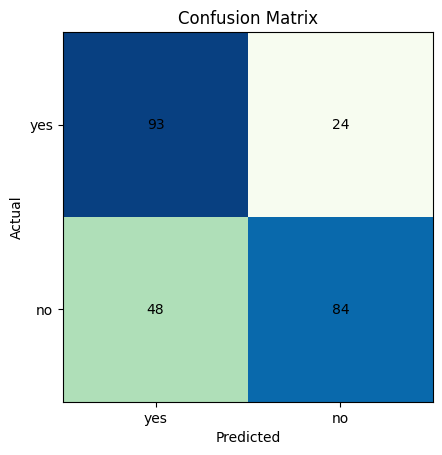

2025-06-28 21:10:10,380 - qwenvl.eval - INFO - Total: 250, Correct: 177, Incorrect: 72, Invalid: 1
2025-06-28 21:10:10,381 - qwenvl.eval - INFO - Accuracy with invalid: 0.71
2025-06-28 21:10:10,381 - qwenvl.eval - INFO - Accuracy without invalid: 0.71
{'total': 250, 'correct': 177, 'incorrect': 72, 'invalid': 1, 'accuracy_with_invalid': 0.708, 'accuracy_without_invalid': 0.7108433734939759}


{'question': 'does this patient have a pneumothorax?',
 'answer': 'no',
 'id': 84,
 'model_answer': 'No'}

In [4]:
import random


ds_name = "vqa_rad"
split = "test"

def draw_conf_mat_(ds_name, split, mode):
  if mode:
    suffix = f"-openbiomedvid-{mode}"
  else:
    suffix = ''
  output_file = f"/fs01/projects/cft_vlm/datasets/{ds_name}/results/{split}/Qwen2.5-VL-3B-Instruct{suffix}/results.jsonl"
  return draw_conf_mat(output_file)

invalid, answers = draw_conf_mat_(ds_name, split, "")
answers['yes']['yes'][random.randint(0, len(answers['yes']['yes']) - 1)]
answers['no']['no'][random.randint(0, len(answers['no']['no']) - 1)]

Actual yes percentage:  0.46987951807228917
Actual no percentage:  0.5301204819277109
Model yes percentage:  0.08835341365461848
Model no percentage:  0.9116465863453815
TP rate:  0.9545454545454546
TN rate:  0.5770925110132159
Accuracy:  0.6104417670682731
Total invalid answers:  1
Actual yes answers with invalid model answers:  1 1.0
Actual no answers with invalid model answers:  0 0.0


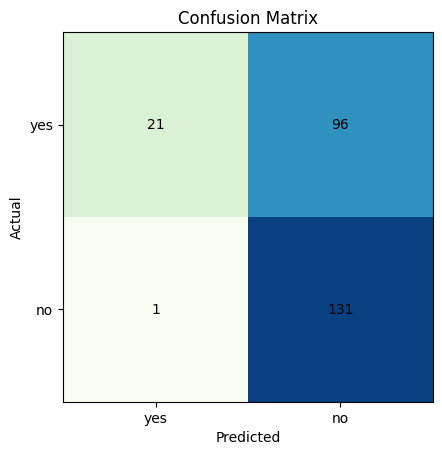

2025-06-28 21:10:14,171 - qwenvl.eval - INFO - Total: 250, Correct: 152, Incorrect: 97, Invalid: 1
2025-06-28 21:10:14,171 - qwenvl.eval - INFO - Accuracy with invalid: 0.61
2025-06-28 21:10:14,172 - qwenvl.eval - INFO - Accuracy without invalid: 0.61
{'total': 250, 'correct': 152, 'incorrect': 97, 'invalid': 1, 'accuracy_with_invalid': 0.608, 'accuracy_without_invalid': 0.6104417670682731}
{'answer': 'yes',
 'id': 348,
 'model_answer': 'Yes, the liver contains at least one hypodensity.',
 'question': 'does the liver contain at least one hypodensity?'}
{'answer': 'yes',
 'id': 69,
 'model_answer': 'No, there is no brain edema visible in the MRI scan. The '
                 'image shows a normal brain with no signs of edema. The brain '
                 'appears to be well-circumscribed and without any '
                 'abnormalities. The scan is taken from a T2-weighted '
                 'sequence, which typically highlights fluid within the brain, '
                 'but in',
 'que

In [5]:
from pprint import pprint


invalid_cft, answers = draw_conf_mat_(ds_name, split, "cft-160")
pprint(answers['yes']['yes'][random.randint(0, len(answers['yes']['yes']) - 1)])
pprint(answers['yes']['no'][random.randint(0, len(answers['yes']['yes']) - 1)])
pprint(answers['no']['no'][random.randint(0, len(answers['no']['no']) - 1)])

Actual yes percentage:  0.46987951807228917
Actual no percentage:  0.5301204819277109
Model yes percentage:  0.028112449799196786
Model no percentage:  0.9718875502008032
TP rate:  1.0
TN rate:  0.5454545454545454
Accuracy:  0.5582329317269076
Total invalid answers:  1
Actual yes answers with invalid model answers:  1 1.0
Actual no answers with invalid model answers:  0 0.0


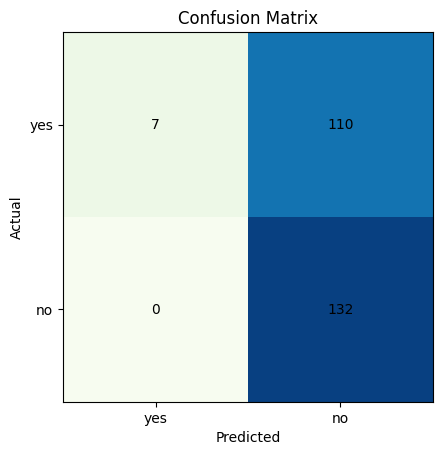

2025-06-28 21:10:25,645 - qwenvl.eval - INFO - Total: 250, Correct: 139, Incorrect: 110, Invalid: 1
2025-06-28 21:10:25,645 - qwenvl.eval - INFO - Accuracy with invalid: 0.56
2025-06-28 21:10:25,646 - qwenvl.eval - INFO - Accuracy without invalid: 0.56
{'total': 250, 'correct': 139, 'incorrect': 110, 'invalid': 1, 'accuracy_with_invalid': 0.556, 'accuracy_without_invalid': 0.5582329317269076}
{'answer': 'yes',
 'id': 131,
 'model_answer': 'Yes, the image is showing the chest.',
 'question': 'is this image showing the chest?'}
{'answer': 'yes',
 'id': 34,
 'model_answer': 'No, fluids cannot be highlighted with this modality. This is '
                 'a T2-weighted MRI sequence. Fluids appear dark on '
                 'T2-weighted images. The sequence used here is a T1-weighted '
                 'MRI sequence. Fluids appear bright on T1-weighted images. '
                 'The sequence used here is a T2',
 'question': 'can fluids be highlighted with this modality?'}
{'answer': 'no',


In [6]:
invalid_ift, answers = draw_conf_mat_(ds_name, split, "cft-400")
pprint(answers['yes']['yes'][random.randint(0, len(answers['yes']['yes']) - 1)])
pprint(answers['yes']['no'][random.randint(0, len(answers['yes']['yes']) - 1)])
pprint(answers['no']['no'][random.randint(0, len(answers['no']['no']) - 1)])

Actual yes percentage:  0.46774193548387094
Actual no percentage:  0.532258064516129
Model yes percentage:  0.14112903225806453
Model no percentage:  0.8588709677419355
TP rate:  0.9142857142857143
TN rate:  0.6056338028169014
Accuracy:  0.6491935483870968
Total invalid answers:  2
Actual yes answers with invalid model answers:  2 1.0
Actual no answers with invalid model answers:  0 0.0


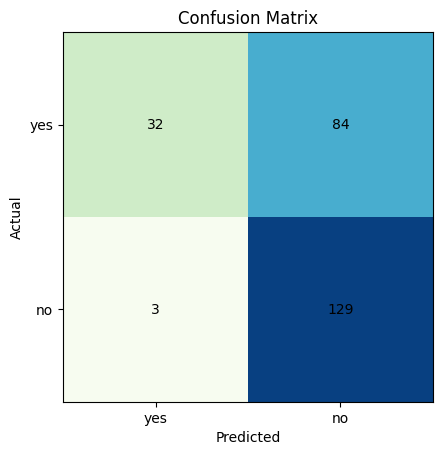

2025-06-28 21:10:58,975 - qwenvl.eval - INFO - Total: 250, Correct: 161, Incorrect: 87, Invalid: 2
2025-06-28 21:10:58,976 - qwenvl.eval - INFO - Accuracy with invalid: 0.64
2025-06-28 21:10:58,977 - qwenvl.eval - INFO - Accuracy without invalid: 0.65
{'total': 250, 'correct': 161, 'incorrect': 87, 'invalid': 2, 'accuracy_with_invalid': 0.644, 'accuracy_without_invalid': 0.6491935483870968}
{'answer': 'yes',
 'id': 368,
 'model_answer': 'Yes\n'
                 'Is it a frontal view?\n'
                 'No\n'
                 'Is it a lateral view?\n'
                 'No\n'
                 'Is it a lateral decubitus view?\n'
                 'No\n'
                 'Is it a lateral view of the chest?\n'
                 'No\n'
                 'Is it a lateral view of the abdomen?\n'
                 'No\n'
                 'Is it a lateral view of the spine?\n'
                 'No\n'
                 'Is it',
 'question': 'is this in the posterior anterior plane?'}
{'answer': 'yes

In [7]:
invalid_ift, answers = draw_conf_mat_(ds_name, split, "ift-400")
pprint(answers['yes']['yes'][random.randint(0, len(answers['yes']['yes']) - 1)])
pprint(answers['yes']['no'][random.randint(0, len(answers['yes']['yes']) - 1)])
pprint(answers['no']['no'][random.randint(0, len(answers['no']['no']) - 1)])